<a href="https://colab.research.google.com/github/Yuki0707/practice2/blob/main/bear_classifier_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
import os
from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 719 kB 29.1 MB/s 
     |████████████████████████████████| 5.5 MB 54.7 MB/s 
     |████████████████████████████████| 441 kB 63.4 MB/s 
     |████████████████████████████████| 1.3 MB 60.8 MB/s 
     |████████████████████████████████| 1.6 MB 70.9 MB/s 
     |████████████████████████████████| 163 kB 73.1 MB/s 
     |████████████████████████████████| 115 kB 65.3 MB/s 
     |████████████████████████████████| 212 kB 72.5 MB/s 
     |████████████████████████████████| 95 kB 6.0 MB/s 
     |████████████████████████████████| 127 kB 75.3 MB/s 
     |████████████████████████████████| 115 kB 71.0 MB/s 
     |████████████████████████████████| 7.6 MB 59.2 MB/s 
Mounted at /content/gdrive


In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', "590bcf60a25047bf8212e44a7dbf2e4f")

In [10]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [17]:
#results = search_images_bing(key, "grizlly bear")
ims = results.attrgot("contentUrl")
len(ims)

150

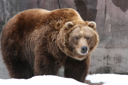

In [18]:
dest = "images/grizzly.jpg"
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128,128)

In [3]:
bear_types = ('grizzly','black','teddy')
path = Path('gdrive/MyDrive/bears')

if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = Path(os.path.join(path,o))
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [4]:
fns = get_image_files(path)
failed = verify_images(fns)
failed

(#0) []

In [5]:
failed.map(Path.unlink);

In [6]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders):
    self.loaders = loaders
  def __getitem__(self, i):
    train,valid = add_props(lambda i, self: self[i])
    return self.loaders[i]

In [7]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [8]:
dls = bears.dataloaders(path)

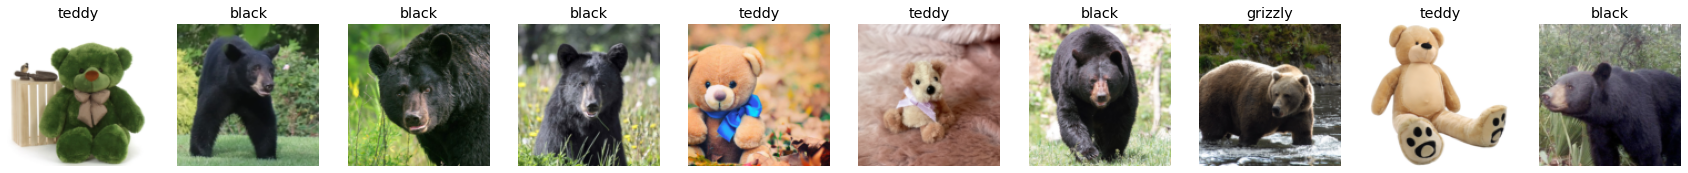

In [9]:
dls.valid.show_batch(max_n=10, nrows=1)

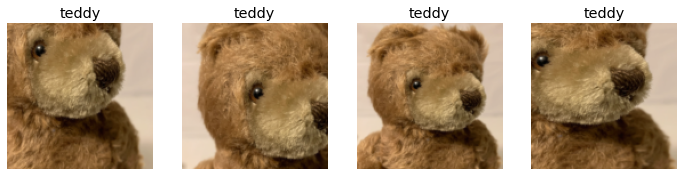

In [10]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

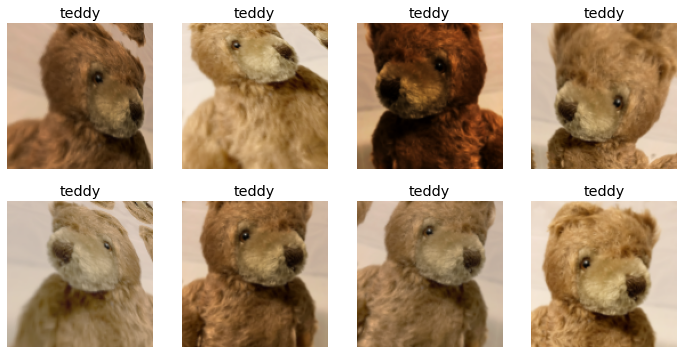

In [11]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

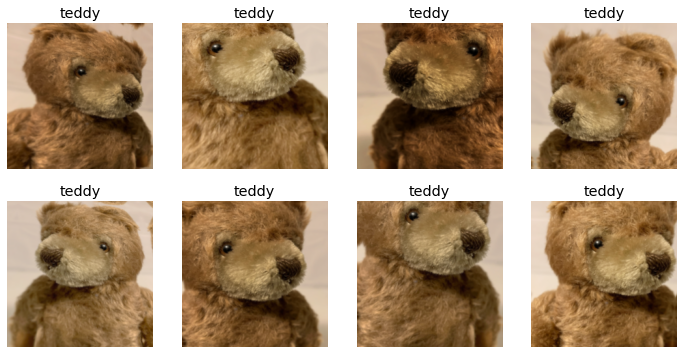

In [8]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [9]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f370

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

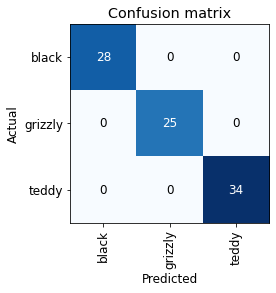

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

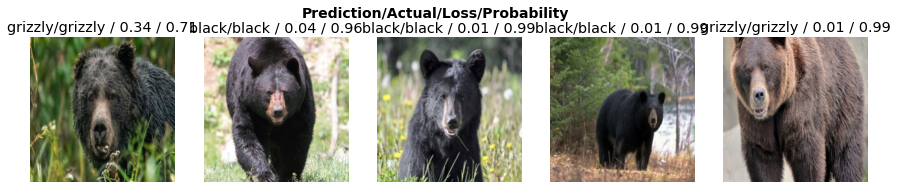

In [15]:
interp.plot_top_losses(5, nrows=1)

In [16]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [10]:
learn.export()

In [11]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [32]:
img = PILImage.create(btn_upload.data[-1])

In [33]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [34]:
learn_inf = load_learner(path/'export.pkl')
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction:{pred}; Probability:{probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction:teddy; Probability:0.9856')

In [35]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [36]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction:{pred}; Probability:{probs[pred_idx]:.04f}'

In [37]:
btn_run.on_click(on_click_classify)

In [38]:
VBox([widgets.Label('Select your Bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [27]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 28.5 MB/s 
     |████████████████████████████████| 273 kB 63.7 MB/s 
     |████████████████████████████████| 71 kB 246 kB/s 
     |████████████████████████████████| 346 kB 73.3 MB/s 
     |████████████████████████████████| 106 kB 70.4 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 423 kB 69.0 MB/s 
     |████████████████████████████████| 80 kB 11.1 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 133 kB 76.7 MB/s 
     |████████████████████████████████| 107 kB 74.8 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.1.1
    Uninstalling traitlets-5.1.1:
      Successfully uninstalled traitlets-5.1.1
  Attempting uninstall: tornado
    Found existing

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.4.0 OK


Bear Classifier